In [8]:
128*128*3
# https://www.kaggle.com/c/bengaliai-cv19/discussion/122993

49152

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2
import albumentations as A
from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Using TensorFlow backend.


dataset/class_map.csv
dataset/my_model.h5
dataset/my_model.json
dataset/my_model_initial.h5
dataset/my_model_initial.json
dataset/sample_submission.csv
dataset/test.csv
dataset/test_image_data_0.parquet
dataset/test_image_data_1.parquet
dataset/test_image_data_2.parquet
dataset/test_image_data_3.parquet
dataset/train.csv
dataset/train_image_data_0.feather
dataset/train_image_data_0.parquet
dataset/train_image_data_1.feather
dataset/train_image_data_1.parquet
dataset/train_image_data_2.feather
dataset/train_image_data_2.parquet
dataset/train_image_data_3.feather
dataset/train_image_data_3.parquet


C:\Users\JeongMyeong\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:

# Any results you write to the current directory are saved as output.

train_df_ = pd.read_csv('dataset/train.csv')
test_df_ = pd.read_csv('dataset/test.csv')
class_map_df = pd.read_csv('dataset/class_map.csv')
sample_sub_df = pd.read_csv('dataset/sample_submission.csv')

In [3]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [4]:
IMG_SIZE=128
N_CHANNELS=1

In [5]:
HEIGHT = 137
WIDTH = 236
SIZE = 128


In [6]:
def resize(df, size, need_progress_bar=True):
    resized = {}
    resize_size=size
    angle=0
    for i in (range(df.shape[0])):
        #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
        image=df.loc[df.index[i]].values.reshape(137,236)
        #Centering
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        matrix = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        image = cv2.warpAffine(image, matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR,
                        borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
        #Scaling
        matrix = cv2.getRotationMatrix2D(image_center, 0, 1.0)
        image = cv2.warpAffine(image, matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR,
                        borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
        #Removing Blur
        aug = A.GaussianBlur(p=1.0)
        image = aug(image=image)['image']
        #Noise Removing
        #augNoise=A.MultiplicativeNoise(p=1.0)
        #image = augNoise(image=image)['image']
        #Removing Distortion
        #augDist=A.ElasticTransform(sigma=50, alpha=1, alpha_affine=10, p=1.0)
        #image = augDist(image=image)['image']
        #Brightness
        _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
            
        idx = 0 
        ls_xmin = []
        ls_ymin = []
        ls_xmax = []
        ls_ymax = []
        for cnt in contours:
            idx += 1
            x,y,w,h = cv2.boundingRect(cnt)
            ls_xmin.append(x)
            ls_ymin.append(y)
            ls_xmax.append(x + w)
            ls_ymax.append(y + h)
        xmin = min(ls_xmin)
        ymin = min(ls_ymin)
        xmax = max(ls_xmax)
        ymax = max(ls_ymax)

        roi = image[ymin:ymax,xmin:xmax]
        resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
        #image=affine_image(image)
        #image= crop_resize(image)
        #image = cv2.resize(image,(size,size),interpolation=cv2.INTER_AREA)
        #image=resize_image(image,(64,64))
        #image = cv2.resize(image,(size,size),interpolation=cv2.INTER_AREA)
        #gaussian_3 = cv2.GaussianBlur(image, (5,5), cv2.BORDER_DEFAULT) #unblur
        #image = cv2.addWeighted(image, 1.5, gaussian_3, -0.5, 0, image)
        #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        #image = cv2.filter2D(image, -1, kernel)
        #ret,image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        resized[df.index[i]] = resized_roi.reshape(-1).astype(np.float32)/255 # Efficient
        if i%500==0:
            gc.collect()# Efficient
    resized = pd.DataFrame(resized).T
    return resized

In [7]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

In [8]:
import keras
from classification_models.keras import Classifiers
seresnext50, preprocess_input = Classifiers.get('seresnext50')
model = seresnext50(input_shape=(IMG_SIZE,IMG_SIZE,1))
x = model.layers[-3].output
head_root = Dense(168, activation = 'softmax')(x)
head_vowel = Dense(11, activation = 'softmax')(x)
head_consonant = Dense(7, activation = 'softmax')(x)

model = Model(input=model.input, output=[head_root, head_vowel, head_consonant])

# model = model_load('/kaggle/input/initial-model/my_model_initial')

model.compile(optimizer='adam', loss='categorical_crossentropy',
          loss_weights=[0.33333, 0.33333, 0.33333],
              metrics=['accuracy'])

C:\Users\JeongMyeong\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  # Remove the CWD from sys.path while we load stuff.


In [9]:
# # Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
# learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_2_accuracy', 
#                                             patience=3, 
#                                             verbose=1,
#                                             factor=0.5, 
#                                             min_lr=0.00001)
# learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_3_accuracy', 
#                                             patience=3, 
#                                             verbose=1,
#                                             factor=0.5, 
#                                             min_lr=0.00001)
# learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_4_accuracy', 
#                                             patience=3, 
#                                             verbose=1,
#                                             factor=0.5, 
#                                             min_lr=0.00001)

In [10]:
#decreased batch size
batch_size = 32
epochs = 24

In [12]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [13]:
%%time
histories = []
liX_train = []
start = time.time()
train_df = pd.read_feather('train.feather')
print('load completed : {:.4f}'.format(time.time()-start))
    # Visualize few samples of current training dataset
X_train = resize(train_df.iloc[:,1:], size=IMG_SIZE)
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

print('resize & reshape completed : {:.4f}'.format(time.time()-start))

Y_train_root = pd.get_dummies(train_df_['grapheme_root']).values
Y_train_vowel = pd.get_dummies(train_df_['vowel_diacritic']).values
Y_train_consonant = pd.get_dummies(train_df_['consonant_diacritic']).values


print(f'Training images: {X_train.shape}')
print(f'Training labels root: {Y_train_root.shape}')
print(f'Training labels vowel: {Y_train_vowel.shape}')
print(f'Training labels consonants: {Y_train_consonant.shape}')


# Divide the data into training and validation set
x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.2, random_state=666)
del train_df
del X_train
del Y_train_root, Y_train_vowel, Y_train_consonant

# Data augmentation for creating more training data
# datagen = MultiOutputDataGenerator(
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.15, # Randomly zoom image 
#     width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=False,  # randomly flip images
#     vertical_flip=False)  # randomly flip images


# This will just calculate parameters required to augment the given data. This won't perform any augmentations
# datagen.fit(x_train)

# Fit the model
history = model.fit(x_train, {'dense_2': y_train_root, 'dense_3': y_train_vowel, 'dense_4': y_train_consonant}, batch_size=batch_size,
                          epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
#                           steps_per_epoch=x_train.shape[0] // batch_size, 
#                           callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant]
                             )

histories.append(history)

# Delete to reduce memory usage
del x_train
del x_test
del y_train_root
del y_test_root
del y_train_vowel
del y_test_vowel
del y_train_consonant
del y_test_consonant
gc.collect()

load completed : 2.4776
resize & reshape completed : 376.7435
Training images: (200840, 128, 128, 1)
Training labels root: (200840, 168)
Training labels vowel: (200840, 11)
Training labels consonants: (200840, 7)
Train on 160672 samples, validate on 40168 samples
Epoch 1/24
160672/160672 [==============================] - 2052s 13ms/step - loss: 0.5963 - dense_2_loss: 1.2419 - dense_3_loss: 0.2934 - dense_4_loss: 0.2536 - dense_2_accuracy: 0.6789 - dense_3_accuracy: 0.9044 - dense_4_accuracy: 0.9158 - val_loss: 0.3555 - val_dense_2_loss: 0.6246 - val_dense_3_loss: 0.2853 - val_dense_4_loss: 0.1562 - val_dense_2_accuracy: 0.8237 - val_dense_3_accuracy: 0.9160 - val_dense_4_accuracy: 0.9499
Epoch 2/24
160672/160672 [==============================] - 2002s 12ms/step - loss: 0.2079 - dense_2_loss: 0.3934 - dense_3_loss: 0.1186 - dense_4_loss: 0.1118 - dense_2_accuracy: 0.8857 - dense_3_accuracy: 0.9655 - dense_4_accuracy: 0.9654 - val_loss: 0.9798 - val_dense_2_loss: 1.6311 - val_dense_3_l

1535

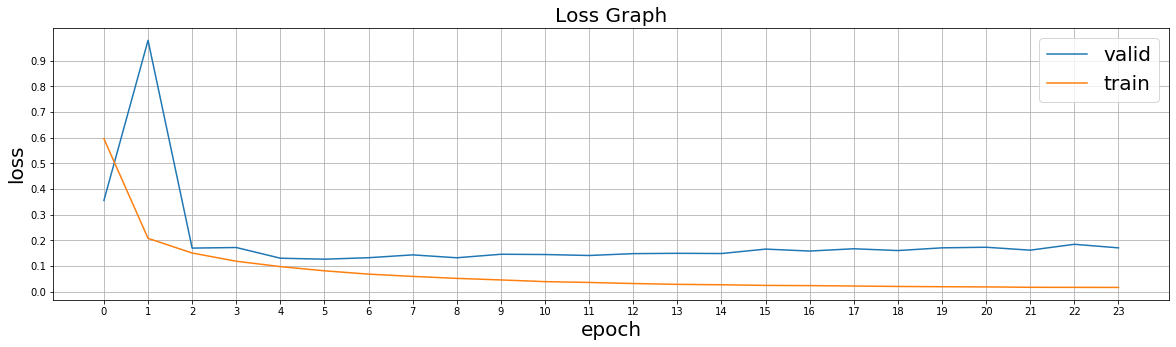

In [37]:
plt.figure(figsize=(20,5))
plt.plot(histories[0].history['val_loss'], label='valid')
plt.plot(histories[0].history['loss'], label='train')
plt.legend(fontsize=20)
plt.yticks([0.1*k for k in range(10)])
plt.xticks(range(24))
plt.title('Loss Graph', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.grid()
plt.savefig('loss graph')

In [17]:
'''load completed : 2.4776
resize & reshape completed : 376.7435
Training images: (200840, 128, 128, 1)
Training labels root: (200840, 168)
Training labels vowel: (200840, 11)
Training labels consonants: (200840, 7)
Train on 160672 samples, validate on 40168 samples
Epoch 1/24
160672/160672 [==============================] - 2052s 13ms/step - loss: 0.5963 - dense_2_loss: 1.2419 - dense_3_loss: 0.2934 - dense_4_loss: 0.2536 - dense_2_accuracy: 0.6789 - dense_3_accuracy: 0.9044 - dense_4_accuracy: 0.9158 - val_loss: 0.3555 - val_dense_2_loss: 0.6246 - val_dense_3_loss: 0.2853 - val_dense_4_loss: 0.1562 - val_dense_2_accuracy: 0.8237 - val_dense_3_accuracy: 0.9160 - val_dense_4_accuracy: 0.9499
Epoch 2/24
160672/160672 [==============================] - 2002s 12ms/step - loss: 0.2079 - dense_2_loss: 0.3934 - dense_3_loss: 0.1186 - dense_4_loss: 0.1118 - dense_2_accuracy: 0.8857 - dense_3_accuracy: 0.9655 - dense_4_accuracy: 0.9654 - val_loss: 0.9798 - val_dense_2_loss: 1.6311 - val_dense_3_loss: 0.7871 - val_dense_4_loss: 0.5207 - val_dense_2_accuracy: 0.5874 - val_dense_3_accuracy: 0.7817 - val_dense_4_accuracy: 0.8404
Epoch 3/24
160672/160672 [==============================] - 1981s 12ms/step - loss: 0.1506 - dense_2_loss: 0.2799 - dense_3_loss: 0.0888 - dense_4_loss: 0.0833 - dense_2_accuracy: 0.9168 - dense_3_accuracy: 0.9751 - dense_4_accuracy: 0.9746 - val_loss: 0.1699 - val_dense_2_loss: 0.3422 - val_dense_3_loss: 0.0826 - val_dense_4_loss: 0.0846 - val_dense_2_accuracy: 0.8991 - val_dense_3_accuracy: 0.9769 - val_dense_4_accuracy: 0.9740
Epoch 4/24
160672/160672 [==============================] - 1983s 12ms/step - loss: 0.1187 - dense_2_loss: 0.2191 - dense_3_loss: 0.0693 - dense_4_loss: 0.0676 - dense_2_accuracy: 0.9336 - dense_3_accuracy: 0.9801 - dense_4_accuracy: 0.9797 - val_loss: 0.1722 - val_dense_2_loss: 0.3295 - val_dense_3_loss: 0.0969 - val_dense_4_loss: 0.0898 - val_dense_2_accuracy: 0.9073 - val_dense_3_accuracy: 0.9732 - val_dense_4_accuracy: 0.9736
Epoch 5/24
160672/160672 [==============================] - 1933s 12ms/step - loss: 0.0977 - dense_2_loss: 0.1782 - dense_3_loss: 0.0586 - dense_4_loss: 0.0562 - dense_2_accuracy: 0.9460 - dense_3_accuracy: 0.9834 - dense_4_accuracy: 0.9833 - val_loss: 0.1304 - val_dense_2_loss: 0.2403 - val_dense_3_loss: 0.0747 - val_dense_4_loss: 0.0760 - val_dense_2_accuracy: 0.9312 - val_dense_3_accuracy: 0.9809 - val_dense_4_accuracy: 0.9793
Epoch 6/24
160672/160672 [==============================] - 1890s 12ms/step - loss: 0.0813 - dense_2_loss: 0.1476 - dense_3_loss: 0.0489 - dense_4_loss: 0.0474 - dense_2_accuracy: 0.9539 - dense_3_accuracy: 0.9862 - dense_4_accuracy: 0.9855 - val_loss: 0.1266 - val_dense_2_loss: 0.2313 - val_dense_3_loss: 0.0746 - val_dense_4_loss: 0.0738 - val_dense_2_accuracy: 0.9351 - val_dense_3_accuracy: 0.9815 - val_dense_4_accuracy: 0.9794
Epoch 7/24
160672/160672 [==============================] - 2001s 12ms/step - loss: 0.0683 - dense_2_loss: 0.1237 - dense_3_loss: 0.0405 - dense_4_loss: 0.0408 - dense_2_accuracy: 0.9613 - dense_3_accuracy: 0.9883 - dense_4_accuracy: 0.9877 - val_loss: 0.1324 - val_dense_2_loss: 0.2412 - val_dense_3_loss: 0.0811 - val_dense_4_loss: 0.0748 - val_dense_2_accuracy: 0.9347 - val_dense_3_accuracy: 0.9805 - val_dense_4_accuracy: 0.9796
Epoch 8/24
160672/160672 [==============================] - 1894s 12ms/step - loss: 0.0595 - dense_2_loss: 0.1060 - dense_3_loss: 0.0365 - dense_4_loss: 0.0362 - dense_2_accuracy: 0.9661 - dense_3_accuracy: 0.9896 - dense_4_accuracy: 0.9889 - val_loss: 0.1434 - val_dense_2_loss: 0.2746 - val_dense_3_loss: 0.0786 - val_dense_4_loss: 0.0771 - val_dense_2_accuracy: 0.9254 - val_dense_3_accuracy: 0.9809 - val_dense_4_accuracy: 0.9786
Epoch 9/24
160672/160672 [==============================] - 1894s 12ms/step - loss: 0.0518 - dense_2_loss: 0.0915 - dense_3_loss: 0.0325 - dense_4_loss: 0.0314 - dense_2_accuracy: 0.9704 - dense_3_accuracy: 0.9901 - dense_4_accuracy: 0.9899 - val_loss: 0.1321 - val_dense_2_loss: 0.2446 - val_dense_3_loss: 0.0788 - val_dense_4_loss: 0.0734 - val_dense_2_accuracy: 0.9365 - val_dense_3_accuracy: 0.9820 - val_dense_4_accuracy: 0.9814
Epoch 10/24
160672/160672 [==============================] - 1894s 12ms/step - loss: 0.0457 - dense_2_loss: 0.0810 - dense_3_loss: 0.0287 - dense_4_loss: 0.0275 - dense_2_accuracy: 0.9737 - dense_3_accuracy: 0.9916 - dense_4_accuracy: 0.9913 - val_loss: 0.1459 - val_dense_2_loss: 0.2689 - val_dense_3_loss: 0.0896 - val_dense_4_loss: 0.0789 - val_dense_2_accuracy: 0.9344 - val_dense_3_accuracy: 0.9795 - val_dense_4_accuracy: 0.9796
Epoch 11/24
160672/160672 [==============================] - 1894s 12ms/step - loss: 0.0391 - dense_2_loss: 0.0686 - dense_3_loss: 0.0244 - dense_4_loss: 0.0244 - dense_2_accuracy: 0.9769 - dense_3_accuracy: 0.9926 - dense_4_accuracy: 0.9922 - val_loss: 0.1448 - val_dense_2_loss: 0.2703 - val_dense_3_loss: 0.0874 - val_dense_4_loss: 0.0766 - val_dense_2_accuracy: 0.9319 - val_dense_3_accuracy: 0.9810 - val_dense_4_accuracy: 0.9807
Epoch 12/24
160672/160672 [==============================] - 1893s 12ms/step - loss: 0.0359 - dense_2_loss: 0.0646 - dense_3_loss: 0.0227 - dense_4_loss: 0.0204 - dense_2_accuracy: 0.9782 - dense_3_accuracy: 0.9930 - dense_4_accuracy: 0.9935 - val_loss: 0.1411 - val_dense_2_loss: 0.2552 - val_dense_3_loss: 0.0824 - val_dense_4_loss: 0.0854 - val_dense_2_accuracy: 0.9390 - val_dense_3_accuracy: 0.9818 - val_dense_4_accuracy: 0.9802
Epoch 13/24
160672/160672 [==============================] - 1896s 12ms/step - loss: 0.0318 - dense_2_loss: 0.0554 - dense_3_loss: 0.0202 - dense_4_loss: 0.0197 - dense_2_accuracy: 0.9816 - dense_3_accuracy: 0.9938 - dense_4_accuracy: 0.9935 - val_loss: 0.1483 - val_dense_2_loss: 0.2700 - val_dense_3_loss: 0.0907 - val_dense_4_loss: 0.0839 - val_dense_2_accuracy: 0.9377 - val_dense_3_accuracy: 0.9807 - val_dense_4_accuracy: 0.9786
Epoch 14/24
160672/160672 [==============================] - 1900s 12ms/step - loss: 0.0285 - dense_2_loss: 0.0508 - dense_3_loss: 0.0178 - dense_4_loss: 0.0170 - dense_2_accuracy: 0.9830 - dense_3_accuracy: 0.9942 - dense_4_accuracy: 0.9944 - val_loss: 0.1495 - val_dense_2_loss: 0.2741 - val_dense_3_loss: 0.0871 - val_dense_4_loss: 0.0870 - val_dense_2_accuracy: 0.9378 - val_dense_3_accuracy: 0.9818 - val_dense_4_accuracy: 0.9806
Epoch 15/24
160672/160672 [==============================] - 1896s 12ms/step - loss: 0.0269 - dense_2_loss: 0.0464 - dense_3_loss: 0.0177 - dense_4_loss: 0.0167 - dense_2_accuracy: 0.9846 - dense_3_accuracy: 0.9944 - dense_4_accuracy: 0.9943 - val_loss: 0.1488 - val_dense_2_loss: 0.2754 - val_dense_3_loss: 0.0873 - val_dense_4_loss: 0.0833 - val_dense_2_accuracy: 0.9385 - val_dense_3_accuracy: 0.9829 - val_dense_4_accuracy: 0.9818
Epoch 16/24
160672/160672 [==============================] - 1897s 12ms/step - loss: 0.0245 - dense_2_loss: 0.0422 - dense_3_loss: 0.0157 - dense_4_loss: 0.0155 - dense_2_accuracy: 0.9857 - dense_3_accuracy: 0.9950 - dense_4_accuracy: 0.9949 - val_loss: 0.1659 - val_dense_2_loss: 0.2912 - val_dense_3_loss: 0.1149 - val_dense_4_loss: 0.0915 - val_dense_2_accuracy: 0.9334 - val_dense_3_accuracy: 0.9772 - val_dense_4_accuracy: 0.9806
Epoch 17/24
160672/160672 [==============================] - 1897s 12ms/step - loss: 0.0236 - dense_2_loss: 0.0413 - dense_3_loss: 0.0150 - dense_4_loss: 0.0145 - dense_2_accuracy: 0.9865 - dense_3_accuracy: 0.9950 - dense_4_accuracy: 0.9951 - val_loss: 0.1584 - val_dense_2_loss: 0.2882 - val_dense_3_loss: 0.0991 - val_dense_4_loss: 0.0879 - val_dense_2_accuracy: 0.9389 - val_dense_3_accuracy: 0.9814 - val_dense_4_accuracy: 0.9820
Epoch 18/24
160672/160672 [==============================] - 1894s 12ms/step - loss: 0.0220 - dense_2_loss: 0.0384 - dense_3_loss: 0.0137 - dense_4_loss: 0.0140 - dense_2_accuracy: 0.9870 - dense_3_accuracy: 0.9956 - dense_4_accuracy: 0.9953 - val_loss: 0.1673 - val_dense_2_loss: 0.3030 - val_dense_3_loss: 0.0935 - val_dense_4_loss: 0.1050 - val_dense_2_accuracy: 0.9337 - val_dense_3_accuracy: 0.9823 - val_dense_4_accuracy: 0.9775
Epoch 19/24
160672/160672 [==============================] - 1894s 12ms/step - loss: 0.0203 - dense_2_loss: 0.0347 - dense_3_loss: 0.0133 - dense_4_loss: 0.0130 - dense_2_accuracy: 0.9883 - dense_3_accuracy: 0.9958 - dense_4_accuracy: 0.9956 - val_loss: 0.1603 - val_dense_2_loss: 0.2927 - val_dense_3_loss: 0.0973 - val_dense_4_loss: 0.0910 - val_dense_2_accuracy: 0.9408 - val_dense_3_accuracy: 0.9819 - val_dense_4_accuracy: 0.9809
Epoch 20/24
160672/160672 [==============================] - 1888s 12ms/step - loss: 0.0193 - dense_2_loss: 0.0341 - dense_3_loss: 0.0123 - dense_4_loss: 0.0115 - dense_2_accuracy: 0.9886 - dense_3_accuracy: 0.9961 - dense_4_accuracy: 0.9961 - val_loss: 0.1709 - val_dense_2_loss: 0.3084 - val_dense_3_loss: 0.1100 - val_dense_4_loss: 0.0941 - val_dense_2_accuracy: 0.9374 - val_dense_3_accuracy: 0.9791 - val_dense_4_accuracy: 0.9804
Epoch 21/24
160672/160672 [==============================] - 1888s 12ms/step - loss: 0.0186 - dense_2_loss: 0.0325 - dense_3_loss: 0.0119 - dense_4_loss: 0.0114 - dense_2_accuracy: 0.9890 - dense_3_accuracy: 0.9962 - dense_4_accuracy: 0.9961 - val_loss: 0.1732 - val_dense_2_loss: 0.3171 - val_dense_3_loss: 0.1009 - val_dense_4_loss: 0.1015 - val_dense_2_accuracy: 0.9369 - val_dense_3_accuracy: 0.9824 - val_dense_4_accuracy: 0.9803
Epoch 22/24
160672/160672 [==============================] - 1987s 12ms/step - loss: 0.0170 - dense_2_loss: 0.0294 - dense_3_loss: 0.0113 - dense_4_loss: 0.0105 - dense_2_accuracy: 0.9901 - dense_3_accuracy: 0.9964 - dense_4_accuracy: 0.9965 - val_loss: 0.1618 - val_dense_2_loss: 0.2970 - val_dense_3_loss: 0.0934 - val_dense_4_loss: 0.0948 - val_dense_2_accuracy: 0.9417 - val_dense_3_accuracy: 0.9836 - val_dense_4_accuracy: 0.9828
Epoch 23/24
160672/160672 [==============================] - 1907s 12ms/step - loss: 0.0168 - dense_2_loss: 0.0284 - dense_3_loss: 0.0111 - dense_4_loss: 0.0108 - dense_2_accuracy: 0.9905 - dense_3_accuracy: 0.9966 - dense_4_accuracy: 0.9963 - val_loss: 0.1847 - val_dense_2_loss: 0.3421 - val_dense_3_loss: 0.1056 - val_dense_4_loss: 0.1060 - val_dense_2_accuracy: 0.9339 - val_dense_3_accuracy: 0.9822 - val_dense_4_accuracy: 0.9794
Epoch 24/24
160672/160672 [==============================] - 1888s 12ms/step - loss: 0.0165 - dense_2_loss: 0.0282 - dense_3_loss: 0.0102 - dense_4_loss: 0.0110 - dense_2_accuracy: 0.9905 - dense_3_accuracy: 0.9966 - dense_4_accuracy: 0.9964 - val_loss: 0.1708 - val_dense_2_loss: 0.3200 - val_dense_3_loss: 0.0953 - val_dense_4_loss: 0.0968 - val_dense_2_accuracy: 0.9372 - val_dense_3_accuracy: 0.9829 - val_dense_4_accuracy: 0.9806
Wall time: 12h 56min 2s'''

'\nload completed : 6.8618\nresize & reshape completed : 503.6353\nTraining images: (200840, 128, 128, 1)\nTraining labels root: (200840, 168)\nTraining labels vowel: (200840, 11)\nTraining labels consonants: (200840, 7)\nTrain on 160672 samples, validate on 40168 samples\nEpoch 1/2\n160672/160672 [==============================] - 1890s 12ms/step - loss: 0.0989 - dense_2_loss: 0.1816 - dense_3_loss: 0.0584 - dense_4_loss: 0.0567 - dense_2_accuracy: 0.9447 - dense_3_accuracy: 0.9835 - dense_4_accuracy: 0.9829 - val_loss: 0.1396 - val_dense_2_loss: 0.2610 - val_dense_3_loss: 0.0820 - val_dense_4_loss: 0.0754 - val_dense_2_accuracy: 0.9284 - val_dense_3_accuracy: 0.9796 - val_dense_4_accuracy: 0.9781\nEpoch 2/2\n160672/160672 [==============================] - 1951s 12ms/step - loss: 0.0818 - dense_2_loss: 0.1486 - dense_3_loss: 0.0492 - dense_4_loss: 0.0478 - dense_2_accuracy: 0.9538 - dense_3_accuracy: 0.9862 - dense_4_accuracy: 0.9856 - val_loss: 0.1407 - val_dense_2_loss: 0.2562 - va

In [ ]:
%%time
histories = []
liX_train = []
for i in range(4):
    print(i)
    train_df = pd.merge(pd.read_feather(f'dataset/train_image_data_{i}.feather'), train_df_, on='image_id').drop(['image_id','grapheme'], axis=1)
    # Visualize few samples of current training dataset
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train, size=IMG_SIZE)/255
    liX_train.append(X_train)
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
#     X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
#     Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
#     Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
#     Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

#     print(f'Training images: {X_train.shape}')
#     print(f'Training labels root: {Y_train_root.shape}')
#     print(f'Training labels vowel: {Y_train_vowel.shape}')
#     print(f'Training labels consonants: {Y_train_consonant.shape}')

#     # Divide the data into training and validation set
#     x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.2, random_state=666)
#     del train_df
#     del X_train
#     del Y_train_root, Y_train_vowel, Y_train_consonant

#     # Data augmentation for creating more training data
#     datagen = MultiOutputDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.15, # Randomly zoom image 
#         width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images


#     # This will just calculate parameters required to augment the given data. This won't perform any augmentations
#     datagen.fit(x_train)

#     # Fit the model
#     history = model.fit_generator(datagen.flow(x_train, {'dense_2': y_train_root, 'dense_3': y_train_vowel, 'dense_4': y_train_consonant}, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
#                               steps_per_epoch=x_train.shape[0] // batch_size, 
#                               callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

#     histories.append(history)
    
#     # Delete to reduce memory usage
#     del x_train
#     del x_test
#     del y_train_root
#     del y_test_root
#     del y_train_vowel
#     del y_test_vowel
#     del y_train_consonant
#     del y_test_consonant
#     gc.collect()

In [ ]:
pd.concat(liX_train)

In [ ]:
## batch size 128
'''Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/1
923/923 [==============================] - 553s 599ms/step - loss: 4.8207 - dense_2_loss: 3.2773 - dense_3_loss: 0.8873 - dense_4_loss: 0.6562 - dense_2_accuracy: 0.2481 - dense_3_accuracy: 0.6958 - dense_4_accuracy: 0.7716 - val_loss: 4.6651 - val_dense_2_loss: 2.9431 - val_dense_3_loss: 1.1564 - val_dense_4_loss: 0.5631 - val_dense_2_accuracy: 0.3620 - val_dense_3_accuracy: 0.6485 - val_dense_4_accuracy: 0.8175
Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/1
923/923 [==============================] - 525s 569ms/step - loss: 1.8598 - dense_2_loss: 1.1508 - dense_3_loss: 0.4067 - dense_4_loss: 0.3023 - dense_2_accuracy: 0.6695 - dense_3_accuracy: 0.8680 - dense_4_accuracy: 0.9015 - val_loss: 3.3413 - val_dense_2_loss: 1.5476 - val_dense_3_loss: 1.4632 - val_dense_4_loss: 0.3349 - val_dense_2_accuracy: 0.5912 - val_dense_3_accuracy: 0.6136 - val_dense_4_accuracy: 0.8880
Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/1
923/923 [==============================] - 507s 549ms/step - loss: 1.3097 - dense_2_loss: 0.7619 - dense_3_loss: 0.3126 - dense_4_loss: 0.2351 - dense_2_accuracy: 0.7802 - dense_3_accuracy: 0.9005 - dense_4_accuracy: 0.9239 - val_loss: 1.1819 - val_dense_2_loss: 0.7511 - val_dense_3_loss: 0.2535 - val_dense_4_loss: 0.1850 - val_dense_2_accuracy: 0.7859 - val_dense_3_accuracy: 0.9253 - val_dense_4_accuracy: 0.9412
Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/1
923/923 [==============================] - 504s 546ms/step - loss: 1.0986 - dense_2_loss: 0.6332 - dense_3_loss: 0.2667 - dense_4_loss: 0.1987 - dense_2_accuracy: 0.8166 - dense_3_accuracy: 0.9181 - dense_4_accuracy: 0.9371 - val_loss: 1.8818 - val_dense_2_loss: 0.8394 - val_dense_3_loss: 0.3831 - val_dense_4_loss: 0.6528 - val_dense_2_accuracy: 0.7618 - val_dense_3_accuracy: 0.8847 - val_dense_4_accuracy: 0.7814
Wall time: 43min 14s'''

In [12]:
from tensorflow.keras.models import model_from_json 
def model_save(MODEL, name):
    model_json = MODEL.to_json()
    with open("{}.json".format(name), "w") as json_file : 
        json_file.write(model_json)
    
    MODEL.save_weights("{}.h5".format(name))
    print("Saved model to disk")
    

def model_load(model_path):
    json_file = open("{}.json".format(model_path), "r") # json 파일을 먼저 로드한 뒤
    loaded_model_json = json_file.read() 
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("{}.h5".format(model_path)) # h5파일을 로드하면서 weight값들을 올려준다.
    print("Loaded")
    return loaded_model # 로드 후 compile은 필수

In [13]:
model_save(model, 'All_Epoch4')

Saved model to disk
